In [1]:
import csv
import numpy as np
import pandas as pd
import re
from gensim.models import KeyedVectors
import morfeusz2
from Levenshtein import distance
from collections import Counter
from sklearn.cluster import DBSCAN
from joblib import Parallel, delayed
import multiprocessing
from tqdm import tqdm  
import os.path
import json
from fbprophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt
from datetime import date
from dateutil.relativedelta import relativedelta
import datetime

Importing plotly failed. Interactive plots will not work.


In [2]:
df_org = pd.read_excel('../shumee_mckinsey -Aktualizacja 01.03.xlsx', index_col=None, engine='openpyxl')

In [3]:
df = df_org[['Data', 'Nazwa produktu']]
df

,Data,Nazwa produktu
0,2021-02-28 23:52:46,PEPCO Ramka na clip 53x63 cm srebrna
1,2021-02-28 23:50:05,shumee Ručně vyrobený kuchyňský dřez se sítkem...
2,2021-02-28 23:50:05,shumee Venkovní solární sprcha se sprchovou hl...
3,2021-02-28 23:48:57,Fontanna ze stali nierdzewnej do basenu ogrodo...
4,2021-02-28 23:39:51,"Krzesła biurowe, 2 szt., pomarańczowe, sztuczn..."
...,...,...
190543,2018-02-26 19:44:13,Kod rabatowy: shumeeLOVE
190544,2018-02-26 15:37:29,U.S. Polo - 43481_47130 XXL
190545,2018-02-26 15:20:26,Made in Italia - FEDERICA 36
190546,2018-02-26 02:08:48,Versace Jeans - E1VPBBT1_75416


In [4]:
clustered_productsJSON = None
clustered_products = {}
id_to_product = {}
with open('./data/clustered_products.json') as f:
    clustered_productsJSON = json.load(f)
for i in clustered_productsJSON:
    for prd in clustered_productsJSON[i]:
        clustered_products[prd] = i

In [5]:
dates = []
begin = datetime.date(2018, 2, 1)
end = datetime.date(2021, 3, 1)
x = datetime.date(2020, 12, 1)
while (begin < end):
    dates.append(begin)
    begin += relativedelta(months=+1)
print(dates)
print(len(dates))

[datetime.date(2018, 2, 1), datetime.date(2018, 3, 1), datetime.date(2018, 4, 1), datetime.date(2018, 5, 1), datetime.date(2018, 6, 1), datetime.date(2018, 7, 1), datetime.date(2018, 8, 1), datetime.date(2018, 9, 1), datetime.date(2018, 10, 1), datetime.date(2018, 11, 1), datetime.date(2018, 12, 1), datetime.date(2019, 1, 1), datetime.date(2019, 2, 1), datetime.date(2019, 3, 1), datetime.date(2019, 4, 1), datetime.date(2019, 5, 1), datetime.date(2019, 6, 1), datetime.date(2019, 7, 1), datetime.date(2019, 8, 1), datetime.date(2019, 9, 1), datetime.date(2019, 10, 1), datetime.date(2019, 11, 1), datetime.date(2019, 12, 1), datetime.date(2020, 1, 1), datetime.date(2020, 2, 1), datetime.date(2020, 3, 1), datetime.date(2020, 4, 1), datetime.date(2020, 5, 1), datetime.date(2020, 6, 1), datetime.date(2020, 7, 1), datetime.date(2020, 8, 1), datetime.date(2020, 9, 1), datetime.date(2020, 10, 1), datetime.date(2020, 11, 1), datetime.date(2020, 12, 1), datetime.date(2021, 1, 1), datetime.date(2021

In [6]:

df['group'] = df['Nazwa produktu'].apply(lambda x: clustered_products[x] if x in clustered_products else -1)
df['ds'] = df['Data'].dt.date.apply(lambda x: x.replace(day=1))
print(df['Data'].min())

df.drop('Data', inplace=True, axis=1)

df.drop('Nazwa produktu', inplace=True, axis=1)
df = df.groupby(by=['ds', 'group']).size().reset_index(name='y')
# train_DF = list(df.loc[(df['DS'] < x)])
# test_DF = list(df.loc[(df['DS'] >= x)].groupby("group"))
splits = list(df.groupby("group"))

<ipython-input-6-627c69d54e01>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['group'] = df['Nazwa produktu'].apply(lambda x: clustered_products[x] if x in clustered_products else -1)
<ipython-input-6-627c69d54e01>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ds'] = df['Data'].dt.date.apply(lambda x: x.replace(day=1))
/home/pk/.local/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats 

2018-02-26 02:08:48


In [7]:
dfSum = df.copy()
dfSum.drop('group', inplace=True, axis=1)
summary_sells = dfSum.groupby('ds').sum().to_dict()['y']
summary_sells

{datetime.date(2018, 2, 1): 24,
 datetime.date(2018, 3, 1): 8,
 datetime.date(2018, 4, 1): 54,
 datetime.date(2018, 5, 1): 16,
 datetime.date(2018, 6, 1): 3,
 datetime.date(2018, 7, 1): 10,
 datetime.date(2018, 8, 1): 58,
 datetime.date(2018, 9, 1): 329,
 datetime.date(2018, 10, 1): 716,
 datetime.date(2018, 11, 1): 1359,
 datetime.date(2018, 12, 1): 2103,
 datetime.date(2019, 1, 1): 1358,
 datetime.date(2019, 2, 1): 2572,
 datetime.date(2019, 3, 1): 3195,
 datetime.date(2019, 4, 1): 4235,
 datetime.date(2019, 5, 1): 4693,
 datetime.date(2019, 6, 1): 3761,
 datetime.date(2019, 7, 1): 2932,
 datetime.date(2019, 8, 1): 2354,
 datetime.date(2019, 9, 1): 2737,
 datetime.date(2019, 10, 1): 2578,
 datetime.date(2019, 11, 1): 4400,
 datetime.date(2019, 12, 1): 4614,
 datetime.date(2020, 1, 1): 5033,
 datetime.date(2020, 2, 1): 5044,
 datetime.date(2020, 3, 1): 5967,
 datetime.date(2020, 4, 1): 9806,
 datetime.date(2020, 5, 1): 9879,
 datetime.date(2020, 6, 1): 8727,
 datetime.date(2020, 7, 1)

In [8]:
splits

[(-1,
                 ds group     y
  0      2018-02-01    -1    16
  7      2018-03-01    -1     5
  11     2018-04-01    -1     8
  43     2018-07-01    -1     1
  206    2018-10-01    -1     1
  771    2018-12-01    -1     1
  1897   2019-02-01    -1    15
  2731   2019-03-01    -1    12
  3791   2019-04-01    -1    15
  5075   2019-05-01    -1    32
  6566   2019-06-01    -1     7
  7584   2019-07-01    -1    23
  8411   2019-08-01    -1    23
  9221   2019-09-01    -1    13
  10185  2019-10-01    -1    47
  11111  2019-11-01    -1   123
  12365  2019-12-01    -1    38
  13775  2020-01-01    -1    22
  15126  2020-02-01    -1    77
  16445  2020-03-01    -1   653
  17752  2020-04-01    -1  1898
  19347  2020-05-01    -1  1699
  20855  2020-06-01    -1  1718
  22253  2020-07-01    -1  2274
  23881  2020-08-01    -1  2455
  25496  2020-09-01    -1  2313
  27203  2020-10-01    -1  8084
  29111  2020-11-01    -1  8745
  30929  2020-12-01    -1  3425
  32608  2021-01-01    -1  4961
  

In [9]:
lst = []
for i in splits:
    s = 0
    for k in i[1].iterrows():
        s+= k[1]['y']
    lst.append((s, i[0]))
lst.sort(reverse=True)
print(lst[:500])
top100sale = []
for i in lst[:100]:
    top100sale.append(i[1])
print(top100sale)

[(43201, -1), (4022, 'lampa'), (2680, 'elastyczne pokrowce'), (2674, 'dywan'), (2335, 'rama łóżka'), (1996, 'szafka nocna'), (1489, 'nakładki na schody'), (1320, 'markiza'), (1249, 'umywalka'), (1028, 'zestaw mebli'), (989, 'zadaszenie do altany'), (942, 'lustro drogowe'), (895, 'parawan panelowy'), (893, 'stolik kawowy'), (878, 'drapak dla'), (858, 'kosz na śmieci'), (792, 'szafka pod'), (786, 'uchwyt do telewizora'), (734, 'plandeka'), (727, 'składany stolik'), (709, 'bawełniana narzuta'), (666, 'roleta'), (664, 'brodzik prysznicowy'), (658, 'szafka na buty'), (617, 'blat stołu'), (601, 'lustro ścienne'), (592, 'półka ścienna'), (560, 'stolik barowy'), (559, 'siatka ogrodzeniowa'), (537, ' zestaw'), (524, 'wieszak na ubrania'), (523, 'wisząca półka'), (521, 'zestaw wypoczynkowy'), (517, 'deska klozetowa'), (477, 'krzesła do jadalni'), (475, 'stolik typu'), (466, 'regał na książki'), (454, 'namiot imprezowy'), (450, 'klatka dla'), (439, 'zaczepy do przyczepki'), (435, 'stojak na paras

In [10]:
train_DF = {}
test_DF = {}
for i in tqdm(splits):
    i[1].drop('group', inplace=True, axis=1)
    newDF = {}
    for k in dates:
        newDF[k] = 0
    for k in i[1].iterrows():
        newDF[k[1]['ds']] = k[1]['y']/summary_sells[k[1]['ds']] #
    localDF=pd.DataFrame(newDF.items(), columns=['ds', 'y'])
    train_DF[i[0]] = localDF.loc[(localDF['ds'] < x)]
    test_DF[i[0]] = localDF.loc[(localDF['ds'] >= x)]

100%|██████████| 8740/8740 [00:27<00:00, 313.35it/s]


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


0    0.077768
1    0.049989
2    0.009840
Name: yhat, dtype: float64
           y  month  year
34  0.012302     12  2020
35  0.008090      1  2021
36  0.012040      2  2021


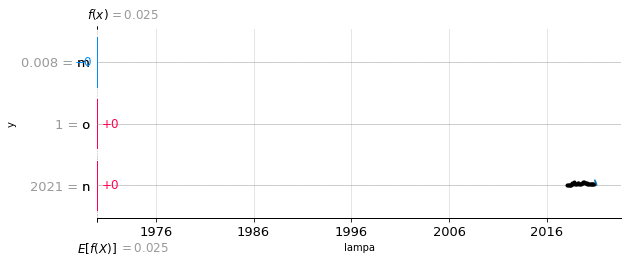

In [38]:
import shap

def build_date_from_row(row):
    if 'year' not in row:
        return datetime.date(2020, 1, 1)
    if 'month' not in row:
        return datetime.date(2020, 1, 1)
    year = row['year']
    month = row['month']
    return datetime.date(year, month, 1)

for k in top100sale[1:2]:
    m = Prophet(seasonality_mode='additive', yearly_seasonality=True)
#     m.add_seasonality('quarterly', period=91.25, fourier_order=8, mode='additive')
    m.fit(train_DF[k])
    forecast = m.predict(test_DF[k])
    print(forecast['yhat'])
    fig1 = m.plot(forecast, xlabel=k)
    def prediction(x):
        df2 = x.copy()
        df2['ds'] = df.apply(lambda row: build_date_from_row(row), axis=1)
        df2.drop('year', inplace=True, axis=1)
        df2.drop('month', inplace=True, axis=1)
        return m.predict(pd.DataFrame(df2, columns=train_DF[k].columns))['yhat']
    
    test2 = test_DF[k].copy()
    test2['month'] = test2['ds'].apply(lambda x : x.month)
    test2['year'] = test2['ds'].apply(lambda x : x.year)
    test2.drop('ds', inplace=True, axis=1)
    print(test2)
    
    explainer = shap.Explainer(prediction, test2)
    shap_values = explainer(test2)
    shap.plots.waterfall(shap_values[1])
#     shap.summary_plot(shap_values, test2)
#     ex = shap.KernelExplainer(prediction, test_DF[k], keep_index=True)
    
#     shap_values = ex.shap_values(test_DF[k])
#     shap.summary_plot(shap_values, train_DF[k])
    print(ex)
    
#     explainer = shap.Explainer(rndForest.predict, test_X)
#     shap_values = explainer(test_X)
